<a href="https://colab.research.google.com/github/jeanmhuang/Quant-Projects/blob/main/stock_market_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Market Analysis with Python
**Author: Jean Huang**

This notebook explores Apple (AAPL) stock over 5 years, computes technical indicators, backtests a simple SMA crossover strategy, and evaluates a machine learning baseline for predicting next-day returns.

**Technologies:** Python, pandas, numpy, matplotlib, scikit-learn, yfinance



In [26]:
!pip install -q yfinance scikit-learn matplotlib pandas numpy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, roc_auc_score
from datetime import datetime, timedelta

plt.rcParams["figure.figsize"] = (10,5)


In [27]:
TICKER = "AAPL"
YEARS = 5

end = datetime.today()
start = end - timedelta(days=365*YEARS)

df = yf.download(TICKER, start=start, end=end, progress=False)
df = df.rename(columns=str.lower)
df.head()


/tmp/ipython-input-415874757.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKER, start=start, end=end, progress=False)


Price,close,high,low,open,volume
Ticker,aapl,aapl,aapl,aapl,aapl
Date,,,,,
2020-08-20,115.048203,115.162497,112.575064,112.592089,126907200
2020-08-21,120.976906,121.460831,115.996588,116.008744,338054800
2020-08-24,122.423820,125.271457,120.556204,125.186335,345937600
2020-08-25,121.419495,121.764813,119.695353,121.295478,211495600
2020-08-26,123.070686,123.527865,121.669970,122.737532,163022400


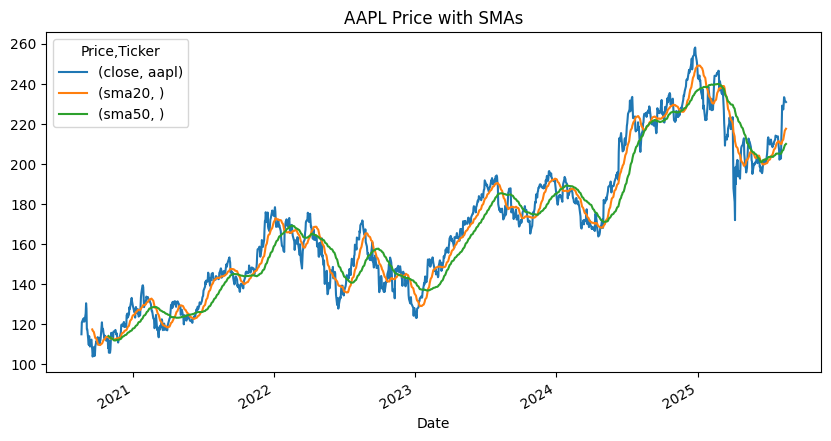

In [28]:
df["sma20"] = df["close"].rolling(20).mean()
df["sma50"] = df["close"].rolling(50).mean()

df[["close","sma20","sma50"]].plot(title=f"{TICKER} Price with SMAs")
plt.show()

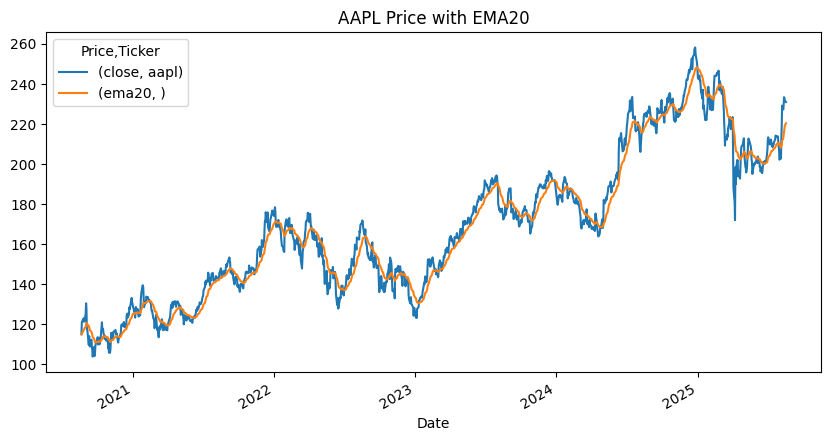

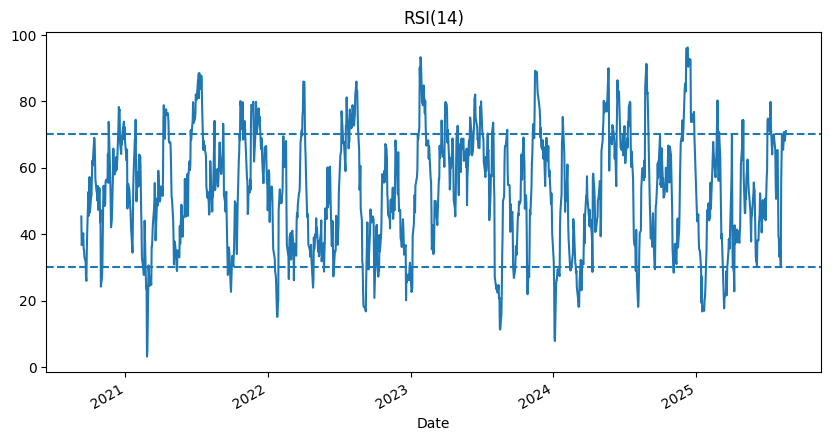

In [29]:
def ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean()
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

df["ema20"] = ema(df["close"], 20)
df["rsi14"] = rsi(df["close"], 14)

df[["close","ema20"]].plot(title=f"{TICKER} Price with EMA20")
plt.show()

df["rsi14"].plot(title="RSI(14)")
plt.axhline(70, linestyle="--"); plt.axhline(30, linestyle="--")
plt.show()

DataFrame info after calculating SMAs:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1254 entries, 2020-08-20 to 2025-08-18
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (close, aapl)   1254 non-null   float64
 1   (high, aapl)    1254 non-null   float64
 2   (low, aapl)     1254 non-null   float64
 3   (open, aapl)    1254 non-null   float64
 4   (volume, aapl)  1254 non-null   int64  
 5   (sma20, )       1235 non-null   float64
 6   (sma50, )       1205 non-null   float64
 7   (ema20, )       1254 non-null   float64
 8   (rsi14, )       1240 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 98.0 KB


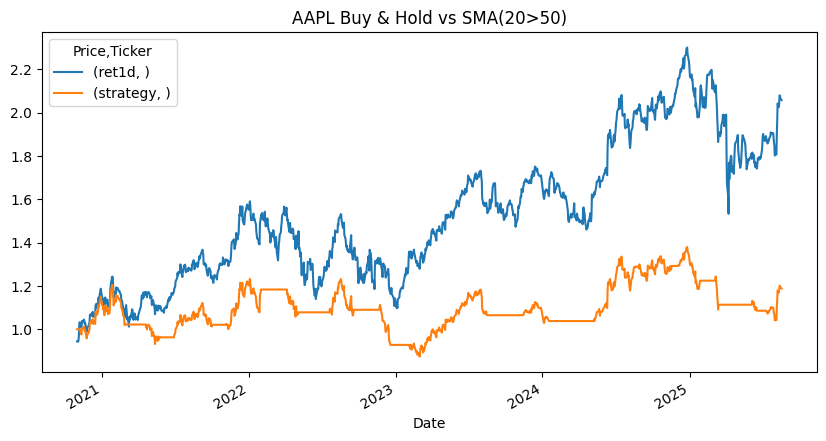

Buy & Hold Sharpe: 0.6718439492970628
Strategy Sharpe: 0.28634267940872166


In [30]:
# Recalculate SMAs to ensure they are in the DataFrame
df[('sma20', '')] = df[('close', 'aapl')].rolling(20).mean()
df[('sma50', '')] = df[('close', 'aapl')].rolling(50).mean()

# Add print statement to inspect df before dropna
print("DataFrame info after calculating SMAs:")
df.info()

# Explicitly select columns after calculating SMAs
data = df[[('close', 'aapl'), ('sma20', ''), ('sma50', '')]].dropna().copy()

data["signal"] = (data[('sma20', '')] > data[('sma50', '')]).astype(int)
data["ret1d"] = data[('close', 'aapl')].pct_change()
data["strategy"] = data["signal"].shift(1) * data["ret1d"]

(1+data[[('ret1d', ''), ('strategy', '')]]).cumprod().plot(title=f"{TICKER} Buy & Hold vs SMA(20>50)")
plt.show()

def sharpe(r):
    return np.sqrt(252) * r.mean() / r.std()

print("Buy & Hold Sharpe:", sharpe(data[('ret1d', '')]))
print("Strategy Sharpe:", sharpe(data[('strategy', '')]))

In [44]:
# === Cell 6 (fixed) — robust ML baseline ===

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 1) Normalize column names and pick a price column
# df = df.copy() # No need to copy here, will work with df directly
# df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns] # Column names are already flattened and cleaned in a previous cell
# Use the correct flattened column name for close
price_col = "c_l_o_s_e___a_a_p_l" # Use the actual flattened column name
assert price_col in df.columns, f"Price column '{price_col}' not found in df.columns: {df.columns.tolist()}"


# 2) Define RSI (redefine here to be safe)
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    roll_up = up.rolling(window).mean()
    roll_down = down.rolling(window).mean().replace(0, np.nan)
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

# 3) Ensure indicators exist (if earlier cells weren’t run)
# Recalculate indicators directly on ml using the flattened close price
ml = df.copy() # Create ml from the updated df
ml["ret1d"] = ml[price_col].pct_change()
ml["y_next_up"] = (ml["ret1d"].shift(-1) > 0).astype(int)

for lag in [1, 2, 3, 5, 10]:
    ml[f"lag{lag}"] = ml["ret1d"].shift(lag)

# Recalculate indicators directly on ml using flattened close price
ml["s_m_a_2_0"] = ml[price_col].rolling(20).mean()
ml["s_m_a_5_0"] = ml[price_col].rolling(50).mean()
ml["e_m_a_2_0"] = ema(ml[price_col], 20) # Assuming ema function is available
ml["r_s_i_1_4"] = rsi(ml[price_col], 14) # Assuming rsi function is available


# 4) Build features/labels
# Use the correct flattened column names for indicators
feature_cols = ["lag1","lag2","lag3","lag5","lag10","s_m_a_2_0","s_m_a_5_0","e_m_a_2_0","r_s_i_1_4"]
target_column = "y_next_up" # Use y_next_up as the target

# Create a new DataFrame with only the relevant columns and drop NaNs
ml_cleaned = ml[feature_cols + [target_column]].dropna().copy()

X = ml_cleaned[feature_cols].values
y = ml_cleaned[target_column].values


# 5) Time-series CV with a simple logistic regression baseline
tscv = TimeSeriesSplit(n_splits=5)
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

accs, aucs = [], []
for i, (tr, te) in enumerate(tscv.split(X, y), 1): # Pass both X and y to split
    pipe.fit(X[tr], y[tr])
    proba = pipe.predict_proba(X[te])[:, 1]
    pred = (proba >= 0.5).astype(int)
    accs.append(accuracy_score(y[te], pred))
    try:
        aucs.append(roc_auc_score(y[te], proba))
    except ValueError:
        aucs.append(np.nan)
    print(f"Fold {i}: Acc={accs[-1]:.3f} | AUC={aucs[-1]:.3f}")

print(f"\nMean Acc: {np.nanmean(accs):.3f} | Mean AUC: {np.nanmean(aucs):.3f}")

AssertionError: Price column 'c_l_o_s_e___a_a_p_l' not found in df.columns: ['c_______________________________________________________________l_______________________________________________________________o_______________________________________________________________s_______________________________________________________________e_______________________________________________________________________________________________________________________________a_______________________________________________________________a_______________________________________________________________p_______________________________________________________________l', 'h_______________________________________________________________i_______________________________________________________________g_______________________________________________________________h_______________________________________________________________________________________________________________________________a_______________________________________________________________a_______________________________________________________________p_______________________________________________________________l', 'l_______________________________________________________________o_______________________________________________________________w_______________________________________________________________________________________________________________________________a_______________________________________________________________a_______________________________________________________________p_______________________________________________________________l', 'o_______________________________________________________________p_______________________________________________________________e_______________________________________________________________n_______________________________________________________________________________________________________________________________a_______________________________________________________________a_______________________________________________________________p_______________________________________________________________l', 'v_______________________________________________________________o_______________________________________________________________l_______________________________________________________________u_______________________________________________________________m_______________________________________________________________e_______________________________________________________________________________________________________________________________a_______________________________________________________________a_______________________________________________________________p_______________________________________________________________l', 's_______________________________________________________________m_______________________________________________________________a_______________________________________________________________2_______________________________________________________________0', 's_______________________________________________________________m_______________________________________________________________a_______________________________________________________________5_______________________________________________________________0', 'e_______________________________________________________________m_______________________________________________________________a_______________________________________________________________2_______________________________________________________________0', 'r_______________________________________________________________s_______________________________________________________________i_______________________________________________________________1_______________________________________________________________4']